In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [5]:
database_path = "Resources/hawaii.sqlite"
engine = sqlalchemy.create_engine(f"sqlite:///{database_path}")

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
Base = automap_base()
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Map Measurement and Station tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Save latest date into a variable and in string type
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

In [12]:
# Find the latest year
date_time_obj = dt.datetime.strptime(latest_date, '%Y-%m-%d') # %H:%M:%S.%f
date_time_obj.year

2017

In [13]:
# Last year from latest date's year
one_year_back = date_time_obj.year - 1
one_year_back

2016

In [14]:
# Reconstruct the date 12 months back from the latest available date
latest_twelve_months_date = dt.date(one_year_back, date_time_obj.month, date_time_obj.day)
latest_twelve_months_date

datetime.date(2016, 8, 23)

In [15]:
# Check which columns does the Measurement table has
# Try with inspect module
from sqlalchemy import inspect

In [16]:
# Use inspect to create an object to check the columns' names
inst = inspect(Measurement)
inst

<Mapper at 0x7fdd64ea8cd0; measurement>

In [17]:
# Get columns' names from Measurement table using mapper method on inst object
attr_names = [c_attr.key for c_attr in inst.mapper.column_attrs]
attr_names

['id', 'station', 'date', 'prcp', 'tobs']

In [18]:
# Try getting columns with reflect module
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Meas = Base.classes.measurement
Sta = Base.classes.station

In [19]:
# Use the session to query Meas table and display the first 5 entries
for row in session.query(Meas.id, Meas.station, Meas.date, Meas.prcp, Meas.tobs).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.date <= latest_date).\
    limit(5).all():
    print(row)

(2365, 'USC00519397', '2016-08-24', 0.08, 79.0)
(2366, 'USC00519397', '2016-08-25', 0.08, 80.0)
(2367, 'USC00519397', '2016-08-26', 0.0, 79.0)
(2368, 'USC00519397', '2016-08-27', 0.0, 77.0)
(2369, 'USC00519397', '2016-08-28', 0.01, 78.0)


In [20]:
# Check count before and after filtering precipitation 'None'
prcp_list = []
date_list = []
for row in session.query(Meas.date, Meas.prcp).\
    order_by(Meas.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all():
    prcp_list.append(row[1])
    date_list.append(row[0])
    #print(f"Date: {row[0]}, precipitation {row[1]}")
len(prcp_list)
print(f"There are {len(prcp_list)} entries including precipitation 'None' values.")    

There are 2015 entries including precipitation 'None' values.


In [23]:
# Convert date list into datetime format for easier handling of plotting
date_list_datetime = pd.to_datetime(date_list)
date_list_datetime

DatetimeIndex(['2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23',
               '2017-08-22', '2017-08-22', '2017-08-22', '2017-08-21',
               '2017-08-21', '2017-08-21',
               ...
               '2016-08-25', '2016-08-25', '2016-08-25', '2016-08-25',
               '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
               '2016-08-24', '2016-08-24'],
              dtype='datetime64[ns]', length=2015, freq=None)

In [24]:
# Save precipitation and date into variables using list comprehension
prcp = [row[1] for row in session.query(Meas.date, Meas.prcp).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]
date = [row[0] for row in session.query(Meas.date, Meas.prcp).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]

In [26]:
# # Create Precipitation dataframe to explore plotting options easier
# prcp_df = pd.DataFrame({'Date': date, 'Precipitation': prcp})
# prcp_df.head()

In [27]:
# Create Precipitation dataframe to explore plotting options easier
prcp_df = pd.DataFrame({'Date': date_list_datetime, 'Precipitation': prcp_list})
prcp_df.head()

,Date,Precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [28]:
type(prcp_df['Date'][0]) # datetime type

pandas._libs.tslibs.timestamps.Timestamp

In [29]:
# Check if grouped by day give 1 year equivalent - 365
grouped_prcp = [row[1] for row in session.query(Meas.date, Meas.prcp).group_by(Meas.date).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]
grouped_date = [row[0] for row in session.query(Meas.date, Meas.prcp).group_by(Meas.date).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]
print(f"There are {len(grouped_date)} entries when group by date, as expected for the latest 12 months.")

There are 365 entries when group by date, as expected for the latest 12 months.


In [30]:
# Create dataframe from the grouped lists for comparison
prcp_grouped_df = pd.DataFrame({'Date': grouped_date, 'Precipitation': grouped_prcp})
len(prcp_grouped_df)

365

In [31]:
#  Check the dataframe columns and their data types
prcp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2015 non-null   datetime64[ns]
 1   Precipitation  2015 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.6 KB


In [32]:
# Use resample method on the Date column to sum grouped by date 'M' month
prcp = prcp_df.set_index('Date').resample('M')["Precipitation"].sum()

In [33]:
# Create data frame from the pandas series above
type(prcp)

pandas.core.series.Series

Text(0, 0.5, 'Accumulated Precipitation')

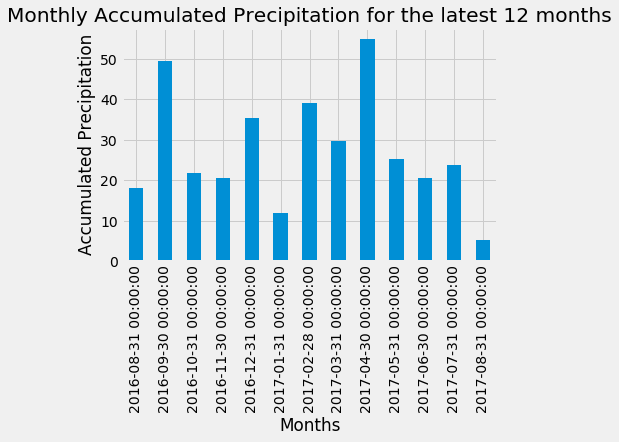

In [34]:
prcp.plot(kind='bar')
plt.title("Monthly Accumulated Precipitation for the latest 12 months")
plt.xlabel("Months")
plt.ylabel("Accumulated Precipitation")

In [35]:
prcp_reset = prcp.reset_index()
prcp_reset.head()

,Date,Precipitation
0,2016-08-31,18.10
1,2016-09-30,49.40
2,2016-10-31,21.77
3,2016-11-30,20.56
4,2016-12-31,35.51


In [36]:
type(prcp_reset)

pandas.core.frame.DataFrame

(array([736208., 736269., 736330., 736389., 736450., 736511., 736573.]),
 <a list of 7 Text xticklabel objects>)

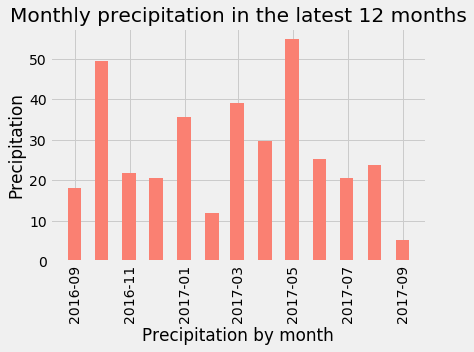

In [37]:
# Plot precipitation using plt.plot() method
x_axis = prcp_reset['Date']
y_axis = prcp_reset['Precipitation']
plt.bar(x_axis, y_axis, color='salmon', width=15, align="center")
plt.title("Monthly precipitation in the latest 12 months")
plt.xlabel("Precipitation by month")
plt.ylabel("Precipitation")
plt.xticks(rotation='vertical')

## Station Analysis

### Total number of stations

In [38]:
# Design a query to calculate the total number of stations.
# Try getting columns with reflect module
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Use inspect to create an object to check the columns' names
inst_sta = inspect(Station)
inst_sta

<Mapper at 0x7fdd65379d30; station>

In [41]:
# Get columns' names from Station table using mapper method on inst object
attr_names = [c_attr.key for c_attr in inst_sta.mapper.column_attrs]
attr_names

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [42]:
# Query all station names
session.query(Station.id, Station.name,  Station.latitude, Station.longitude, Station.elevation).all()

[(1, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [43]:
# Query the stations and count the number
station_count = session.query(Station.id).count()
print(f"There are total of {station_count} stations in Station table.")

There are total of 9 stations in Station table.


### Highest altitude station

In [44]:
# Design a query to find the most active stations
  # a. List the stations and observation counts in descending order.
  # b. Which station has the highest number of observations?
  # Hint: You will need to use a function such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

In [46]:
# Design a query to find the highest altitude stations
# a. List the stations and elevations in descending order.
sta_elev_desc = session.query(Station.elevation, Station.name).\
    order_by(Station.elevation.desc()).all()
sta_elev_desc

[(306.6, 'UPPER WAHIAWA 874.3, HI US'),
 (152.4, 'MANOA LYON ARBO 785.2, HI US'),
 (32.9, 'WAIHEE 837.5, HI US'),
 (19.5, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (14.6, 'KANEOHE 838.1, HI US'),
 (11.9, 'PEARL CITY, HI US'),
 (7.0, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (3.0, 'WAIKIKI 717.2, HI US'),
 (0.9, 'HONOLULU OBSERVATORY 702.2, HI US')]

In [47]:
#b. Which station has the highest elevation?
sta_highest_elevation = session.query(Station.elevation, Station.name).\
    order_by(Station.elevation.desc()).first()
print(f"The {sta_highest_elevation[1].split(',')[0]} station - Elev: {sta_highest_elevation[0]}.")

The UPPER WAHIAWA 874.3 station - Elev: 306.6.


In [48]:
#b. Write a function to identify which station has the highest elevation?
def get_station_with_highest_elevation(table_name):
    # Get the highest elevation value using func.max()
    sta_highest_elevation = session.query(func.max(table_name.elevation)).first()
    # Save the first index from the results into sta_highest_elevation variable
    sta_highest_elevation = sta_highest_elevation[0]
    # Query and save the name of the station with the highest elevation
    sta_high_name = session.query(Station.name, Station.elevation).\
    filter(Station.elevation == sta_highest_elevation).first()
    # Convert result to a string and get the name of the station
    sta_high_name_str = str(sta_high_name[0])
    sta_high_name_str = sta_high_name_str.split(',')[0]
    # Return the two variables
    return sta_highest_elevation, sta_high_name_str

In [49]:
#b. Write a function to identify which station has the highest observation?
def get_station_with_highest_observation(table_name):
    # Get the highest observation value using func.max()
    sta_highest_observation = session.query(func.max(table_name.tobs)).first()
    # Save the first index from the results into sta_highest_observation variable
    sta_highest_observation = sta_highest_observation[0]
    # Query and save the name of the station with the highest observation
    sta_high_tobs_name = session.query(table_name.station, table_name.tobs).\
    filter(table_name.tobs == sta_highest_observation).first()
    # Convert result to a string and get the name of the station
    sta_high_tobs_name_str = str(sta_high_tobs_name[0])
    sta_high_tobs_name_str = sta_high_tobs_name_str.split(',')[0]
    # Return the two variables
    return sta_highest_observation, sta_high_tobs_name_str

In [50]:
# Call the function to get the highest elevation and the name of the station
get_station_with_highest_elevation(Station)

(306.6, 'UPPER WAHIAWA 874.3')

In [51]:
# Call the function to get the highest elevation and the name of the station
get_station_with_highest_observation(Measurement)

(87.0, 'USC00519397')

### Last 12 months of temperature observation data (TOBS)

In [52]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS)
stations = session.query(Measurement.station, Measurement.tobs).all()
len(stations)

19550

In [53]:
# Create and run a query for the latest 12 months, sorted by 'tobs' in descending order
session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    order_by(Measurement.tobs.desc()).\
    filter(Measurement.date <= latest_date).\
    filter(Measurement.date > latest_twelve_months_date).\
    filter(Measurement.tobs != 'None').\
    all()

[('2017-05-23', 'USC00519397', 87.0),
 ('2017-07-03', 'USC00517948', 87.0),
 ('2017-08-19', 'USC00519523', 85.0),
 ('2016-08-26', 'USC00519523', 84.0),
 ('2016-09-04', 'USC00519523', 84.0),
 ('2016-09-05', 'USC00519523', 84.0),
 ('2017-07-26', 'USC00519523', 84.0),
 ('2017-07-30', 'USC00519523', 84.0),
 ('2017-08-13', 'USC00519523', 84.0),
 ('2017-06-12', 'USC00519397', 83.0),
 ('2017-04-19', 'USC00514830', 83.0),
 ('2016-09-11', 'USC00519523', 83.0),
 ('2016-09-24', 'USC00519523', 83.0),
 ('2017-07-18', 'USC00519523', 83.0),
 ('2017-07-29', 'USC00519523', 83.0),
 ('2017-08-02', 'USC00519523', 83.0),
 ('2017-08-06', 'USC00519523', 83.0),
 ('2017-08-07', 'USC00519523', 83.0),
 ('2017-08-12', 'USC00519523', 83.0),
 ('2017-08-17', 'USC00519523', 83.0),
 ('2017-08-06', 'USC00519281', 83.0),
 ('2016-09-23', 'USC00519397', 82.0),
 ('2017-07-26', 'USC00519397', 82.0),
 ('2017-08-22', 'USC00519397', 82.0),
 ('2017-06-21', 'USC00513117', 82.0),
 ('2016-09-01', 'USC00514830', 82.0),
 ('2016-09-0

In [54]:
# Create a list with observations in descending order
tobs_date_list = []
tobs_sta_list  = []
tobs_list      = []
for row in session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    order_by(Measurement.tobs.desc()).\
    filter(Measurement.date <= latest_date).\
    filter(Measurement.date > latest_twelve_months_date).\
    filter(Measurement.tobs != 'None').\
    all():
    tobs_date_list.append(row[0])
    tobs_sta_list.append(row[1])
    tobs_list.append(row[2])
print(f"Date: {row[0]}; Station: {row[1]}; Observations: {row[2]}.")

Date: 2017-04-30; Station: USC00516128; Observations: 58.0.


In [55]:
print(f"There are {len(tobs_list)} entries.")    

There are 2223 entries.


In [56]:
# a. Filter by the station with the highest number of observations.
def get_station_with_highest_observation(table_name):
    # Get the highest observation value using func.max()
    sta_highest_observation = session.query(func.max(table_name.tobs)).first()
    # Save the first index from the results into sta_highest_observation variable
    sta_highest_observation = sta_highest_observation[0]
    # Query and save the name of the station with the highest observation
    sta_high_tobs_name = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.tobs == sta_highest_observation).first()
    # Convert result to a string and get the name of the station
    sta_high_tobs_name_str = str(sta_high_tobs_name[0])
    sta_high_tobs_name_str = sta_high_tobs_name_str.split(',')[0]
    # Return the two variables
    return sta_highest_observation, sta_high_tobs_name_str

In [57]:
get_station_with_highest_observation(Measurement)

(87.0, 'USC00519397')

### b. Plot the results as a histogram with `bins=12`


In [59]:
# Convert date list into datetime format 
tobs_date_list_datetime = pd.to_datetime(tobs_date_list)

In [60]:
# Check the lengths of the lists
print(f"Date: {len(tobs_date_list_datetime)}, Stations: {len(tobs_sta_list)}, Observations: {len(tobs_list)}.")

Date: 2223, Stations: 2223, Observations: 2223.


In [61]:
# Create dataframe with tobs_sta_list, tobs_list and tobs_date_list data
df = pd.DataFrame({'Temp. Observed (DegF)': tobs_list, 'Date': tobs_date_list_datetime, 
                        'Station': tobs_sta_list})
df

,Temp. Observed (DegF),Date,Station
0,87.0,2017-05-23,USC00519397
1,87.0,2017-07-03,USC00517948
2,85.0,2017-08-19,USC00519523
3,84.0,2016-08-26,USC00519523
4,84.0,2016-09-04,USC00519523
...,...,...,...
2218,60.0,2017-02-02,USC00516128
2219,59.0,2017-02-02,USC00519281
2220,59.0,2017-02-08,USC00519281
2221,59.0,2017-02-09,USC00519281


In [62]:
# Check maximum observed temperature, extract the list, then extract first index in the list
tobs_max_latest_12_months = session.query(func.max(Measurement.tobs)).all()[0][0]
tobs_max_latest_12_months

87.0

In [63]:
# Check minimum observed temperature, extract the list, then extract first index in the list
tobs_min_latest_12_months = session.query(func.min(Measurement.tobs)).all()[0][0]
tobs_min_latest_12_months

53.0

In [64]:
# Create bins for months in the past 12 months
latest_date

'2017-08-23'

In [65]:
# Check the latest_twelve_months_date value and time
latest_twelve_months_date

datetime.date(2016, 8, 23)

In [66]:
# # Create bins based on min and max dates
# tobs_df = pd.DataFrame(pd.date_range(latest_twelve_months_date, freq='1M', periods=12), columns=['Date'])
# tobs_df

In [67]:
# Cut pd series into bins by months
bins_dt = pd.date_range(latest_twelve_months_date, freq='1M', periods=12)
bins_str = bins_dt.astype(str).values
bins_str

array(['2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
       '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
       '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31'],
      dtype=object)

In [68]:
# Create lables 
labels = ['({}, {}]'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]

df['cut'] = pd.cut(df.Date.astype(np.int64)//10**9,
                   bins=bins_dt.astype(np.int64)//10**9,
                   labels=labels)
df.head(100)

,Temp. Observed (DegF),Date,Station,cut
0,87.0,2017-05-23,USC00519397,"(2017-04-30, 2017-05-31]"
1,87.0,2017-07-03,USC00517948,"(2017-06-30, 2017-07-31]"
2,85.0,2017-08-19,USC00519523,NaN
3,84.0,2016-08-26,USC00519523,NaN
4,84.0,2016-09-04,USC00519523,"(2016-08-31, 2016-09-30]"
...,...,...,...,...
95,81.0,2017-05-31,USC00514830,"(2017-04-30, 2017-05-31]"
96,81.0,2017-06-01,USC00514830,"(2017-05-31, 2017-06-30]"
97,81.0,2017-06-05,USC00514830,"(2017-05-31, 2017-06-30]"
98,81.0,2017-06-07,USC00514830,"(2017-05-31, 2017-06-30]"


In [69]:
# Sort dataframe by date column in descending order
sorted_df = df.sort_values(by='Date', ascending=False)
sorted_df.head()

,Temp. Observed (DegF),Date,Station,cut
58,82.0,2017-08-23,USC00519523,NaN
81,81.0,2017-08-23,USC00519397,NaN
38,82.0,2017-08-23,USC00514830,NaN
1079,76.0,2017-08-23,USC00516128,NaN
57,82.0,2017-08-22,USC00519523,NaN


### Create data frame sorted by Date in descending order

In [70]:
# Create df from query by Date in descending order
tobs_date_desc_list = []
tobs_sta_desc_list  = []
tobs_desc_list      = []
for row in session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.date <= latest_date).\
    filter(Measurement.date > latest_twelve_months_date).\
    filter(Measurement.tobs != 'None').\
    all():
    tobs_date_desc_list.append(row[0])
    tobs_sta_desc_list.append(row[1])
    tobs_desc_list.append(row[2])
print(f"Date: {row[0]}; Station: {row[1]}; Observations: {row[2]}.")

Date: 2016-08-24; Station: USC00516128; Observations: 74.0.


In [71]:
# Convert date list into datetime format 
tobs_date_list_desc_datetime = pd.to_datetime(tobs_date_desc_list)

In [72]:
# Create dataframe sorted by date in descending order
desc_df = pd.DataFrame({'Date': tobs_date_list_desc_datetime, 
                   'Temp. Observed (DegF)': tobs_desc_list, 'Station': tobs_sta_desc_list})
desc_df.head(30)

,Date,Temp. Observed (DegF),Station
0,2017-08-23,81.0,USC00519397
1,2017-08-23,82.0,USC00514830
2,2017-08-23,82.0,USC00519523
3,2017-08-23,76.0,USC00516128
4,2017-08-22,82.0,USC00519397
5,2017-08-22,82.0,USC00519523
6,2017-08-22,76.0,USC00516128
7,2017-08-21,81.0,USC00519397
8,2017-08-21,79.0,USC00514830
9,2017-08-21,82.0,USC00519523


Text(0, 0.5, 'Temp. Observed - Frequency')

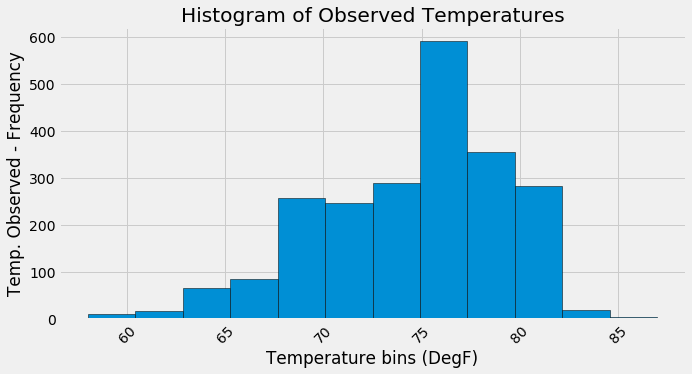

In [75]:
desc_df['Temp. Observed (DegF)'].hist(bins=12, xrot=45, figsize=(10,5), ec="k")
# [x.title.set_size(12) for x in fig.ravel()]
plt.title("Histogram of Observed Temperatures")
plt.xlabel("Temperature bins (DegF)")
plt.ylabel("Temp. Observed - Frequency")
plt.legend("Frequency observed")

## Bonus Challenge Assignment

In [83]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    1. Assume the input is correctly formatted to %Y-%m-%d
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [84]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps(latest_twelve_months_date, latest_date)

[(58.0, 74.59058295964125, 87.0)]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")

In [111]:
# y_axis = calc_temps
# type(calc_temps(latest_twelve_months_date, latest_date))
results = calc_temps(latest_twelve_months_date, latest_date)
# print(results[0])
#type(results[0])
list_result = list(results[0])
type(list_result)
temp_min = list_result[0]
temp_avg = list_result[1]
temp_max = list_result[2]
print(f"Min temp: {temp_min}, temp_avg: {temp_avg}, temp_max: {temp_max}.")
# temp_df = pd.DataFrame({'Temp. Min': temp_min, 'Temp. Average': temp_avg, 'Temp. Max:' temp_max})
# temp_df
# split_result_string = results[0].split(',')
# split_str = (calc_temps(latest_twelve_months_date, latest_date))[0].split(', ')
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Min temp: 58.0, temp_avg: 74.59058295964125, temp_max: 87.0.


In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [40]:
# Plot the daily normals as an area plot with `stacked=False`
